# Image Denoising Project
  
**T**  
..**E**  
...**A**  
.....**M**  
Mac **C**arr  
Kevin **L**ata  
Michael **A**ngino  
Daniel **R**othfusz  
Elise **G**ibney  

In [12]:
import scipy.io as sc
from scipy import fft
from scipy import signal
import numpy as np
import matplotlib
import matplotlib.image as im
import matplotlib.pyplot as plt
import time
import struct
from sklearn.metrics.pairwise import  cosine_similarity
from os import path, listdir
import math
import pythran_openblas as openblas
import bm3d

## Import image files into the project

@Michael, Run this section to import all the files

In [13]:
# Import dataset
files = [] # list of 
files_to_import = listdir("dataset1")
files_to_import.sort()
for fil in files_to_import:
    split = fil.split('.')
    if len(split) > 1:
        if split[1] in ['png', 'jpg', 'tif']: # Accepted filetypes, if we have any other valid types, put them here
            data = plt.imread(f'dataset1/{fil}').astype(np.float32)
            if data.max() > 1:
                data = data / 255
            files.append({"name": split[0], "raw_data": data})
for entry in files:
    if len(entry["raw_data"].shape) > 2:
        entry["type"] = "color"
    else:
        entry["type"] = "grey"



In [14]:
# Import Grey Images

names = ["cameraman", "lena_gray_256", "lena_gray_512", "livingroom", "mandril_gray", "pirate", "woman_blonde", "woman_darkhair"]
variances = ["001", "005", "01", "025"] 
grey_files = []
for name in names:
    img_dict = {}
    img_dict["raw_data"] = plt.imread(f"grey/{name}_original.png")
    img_dict["name"] = name
    img_dict["type"] = "grey"
    for variance in variances:
        img_dict[f"noisy_{variance}"] = plt.imread(f"grey/{name}_{variance}.png")
        img_dict[f"mse_{variance}"] = np.sum(np.square(img_dict["raw_data"] - img_dict[f"noisy_{variance}"]))
    grey_files.append(img_dict)




In [15]:
# Import Test Image Data
names = ["cameraman", "mandril_gray", "pirate"]
variances = ["001", "005", "01", "025"] 
test_files = []
for name in names:
    img_dict = {}
    img_dict["raw_data"] = plt.imread(f"test_images/{name}_original.png")
    img_dict["name"] = name
    img_dict["type"] = "grey"
    for variance in variances:
        img_dict[f"noisy_{variance}"] = plt.imread(f"test_images/{name}_{variance}.png")
        img_dict[f"mse_{variance}"] = np.sum(np.square(img_dict["raw_data"] - img_dict[f"noisy_{variance}"]))
    test_files.append(img_dict)

img_dict = {}
img_dict["raw_data"] = plt.imread(f"test_images/motor_original.png")[:,:,0:3]
img_dict["name"] = "motor"
img_dict["type"] = "color"
for variance in variances:
    img_dict[f"noisy_{variance}"] = plt.imread(f"test_images/motor_{variance}.png")[:,:,0:3]
    img_dict[f"mse_{variance}"] = np.sum(np.square(img_dict["raw_data"] - img_dict[f"noisy_{variance}"]))
test_files.append(img_dict)


In [ ]:
# # Export grey images

# from PIL import Image

# for img in files:
#     if img["type"] == "grey":
#         current = img["raw_data"]

            # current = img["raw_data"]
            # noise01 = (current + np.random.normal(0, np.sqrt(0.01), current.shape)).clip(0,1)
            # noise025 = (current + np.random.normal(0, np.sqrt(0.025), current.shape)).clip(0,1)
            # noise005 = (current + np.random.normal(0, np.sqrt(0.005), current.shape)).clip(0,1)
            # noise001 = (current + np.random.normal(0, np.sqrt(0.001), current.shape)).clip(0,1)


            # im = Image.fromarray(current * 255)
            # im = im.convert('RGB')
            # im.save(f'test_images/{img["name"]}_original.png', "png")
            # imn1 = Image.fromarray(noise01 * 255)
            # imn1 = imn1.convert('RGB')
            # imn1.save(f'test_images/{img["name"]}_01.png', "png")
            # imn2 = Image.fromarray(noise025 * 255)
            # imn2 = imn2.convert('RGB')
            # imn2.save(f'test_images/{img["name"]}_025.png', "png")
            # imn3 = Image.fromarray(noise005 * 255)
            # imn3 = imn3.convert('RGB')
            # imn3.save(f'test_images/{img["name"]}_005.png', "png")
            # imn4 = Image.fromarray(noise001 * 255)
            # imn4 = imn4.convert('RGB')
            # imn4.save(f'test_images/{img["name"]}_001.png', "png")



# img_in = plt.imread("grey/cameraman_original.png")
# print(img_in.shape)
# print(img_in.max())
# img_original = plt.imread("grey/cameraman_001.png")
# # print(img_original.shape)
# print(np.sum(np.square(img_in - img_original)))
# img_original = plt.imread("grey/cameraman_005.png")
# print(np.sum(np.square(img_in - img_original)))
# img_original = plt.imread("grey/cameraman_01.png")
# print(np.sum(np.square(img_in - img_original)))
# img_original = plt.imread("grey/cameraman_025.png")
# print(np.sum(np.square(img_in - img_original)))

#Exporting images
# variances = [0, 0.001, 0.005, 0.01, 0.025, 0.05]
# for variance in variances:
#     img = files[5]
#     noise = (img["raw_data"] + np.random.normal(0,np.sqrt(variance), img["raw_data"].shape)).clip(0, 1)
#     # plt.imsave(f"exports/{img['name']}_{variance}.png", noise)
#     print(f'Image {variance}')
#     print(np.sum(np.square(img["raw_data"] - noise)))

Overall data stored in "files" list.

Each image contained in its own dictionary with the following keys (update as stuff is added):

- name -> filename of the input image
- raw_data -> image unaltered except for normalization to range 0-1
- type -> "grey" or "color" to help determine necessary operations
- noisy_\[variance] -> raw_data + gaussian noise added with variance determined below, clipped to range 0-1
- mse_\[variance] -> mean squared error of the noisy image from the original image (NOTE not normalized per pixel, just the whole sum)

In [ ]:
# To show all images: 

# for entry in files:
#     plt.title(entry["name"])
#     plt.imshow(entry["raw_data"], cmap="magma")
#     plt.show()

## Noise
This section adds noise to the images. Amount of noise is specified by "variance"

Run the first code block to add noise, the second one is just if you want to look at them/analyze the noise

Notes: 
- Noise function takes in std deviation, so we take the square root of the variance
- variance = 0.01 seems to be a good amount of noise, but we should experiment with other values.
- [Link to display range of Normal Distrubution](https://homepage.divms.uiowa.edu/~mbognar/applets/normal.html)

In [18]:
# Add noise (Gaussian)
variance = .01
variance_levels = [0.001, 0.005, 0.01, 0.025]
# Other options: 0.005 for less, 0.025 for high-moderate noise, .04 for a lot 

for entry in files:
        for variance in variance_levels:
                entry["noisy"] = (entry["raw_data"] + np.random.normal(0, np.sqrt(variance), entry["raw_data"].shape)).clip(0,1)
                entry["mse"] = np.square(entry["noisy"] - entry["raw_data"]).sum().sum()
        # print(entry["mse"])

In [ ]:
# Show noise

# To show images
for entry in files:
    plt.title(entry["name"])
    if entry["type"] == "grey":
        plt.imshow(entry["noisy"], cmap="magma")
        plt.colorbar()
        print(np.abs(entry["raw_data"] - entry["noisy"]).mean())
    else:
        plt.imshow(entry["noisy"])
        print(np.abs(entry["raw_data"] - entry["noisy"]).mean())
    plt.show()

## Linear filter
In this section, we are implementing a linear filter to denoise the image. More info to come.

Notes: Impossible to achieve perfect results, especially with a linear filter. 

Things to try:
- Mean filtering
- LPF of various types [LPF Examples](http://fourier.eng.hmc.edu/e101/lectures/Image_Processing/node8.html)


In [ ]:
# Linear Filter

# Defining Linear filters


def apply_ideal_lpf(img_dict, type_to_filter):
    """ 
    Takes in img_dict from files list and string key of img to filter ("raw_data" or "noisy")
    Outputs the image specified filtered with an ideal LPF
    """
    img = img_dict[type_to_filter]
    img_type = img_dict["type"]
    if img_type == "color":
        FSr = np.fft.fftn(img[:,:,0])
        FSg = np.fft.fftn(img[:,:,1])
        FSb = np.fft.fftn(img[:,:,2])
        ideal_low_pass = np.zeros(img[:,:,0].shape)
    else:
        FS = np.fft.fftn(img)
        ideal_low_pass = np.zeros(img.shape)

    centery = img.shape[0] / 2
    centerx = img.shape[1] / 2

    d =30 # Distance of cutoff
    for y in range(img.shape[0]):
        for x in range(img.shape[1]):
            y_rel = y-centery
            x_rel = x-centerx
            if (np.sqrt(np.square(y_rel)+ np.square(x_rel)) <d):
                ideal_low_pass[y,x] = 1

    # Apply Ideal low pass
    if img_type == "color":
        transformr = np.multiply(np.fft.fftshift(FSr), ideal_low_pass) 
        transformg = np.multiply(np.fft.fftshift(FSg), ideal_low_pass)
        transformb = np.multiply(np.fft.fftshift(FSb), ideal_low_pass)
        result = np.zeros(img.shape)
        result[:,:,0] = np.fft.ifftn(np.fft.ifftshift(transformr)).real
        result[:,:,1] = np.fft.ifftn(np.fft.ifftshift(transformg)).real
        result[:,:,2] = np.fft.ifftn(np.fft.ifftshift(transformb)).real
    else:
        transform = np.multiply(np.fft.fftshift(FS), ideal_low_pass)
        result = np.fft.ifftn(np.fft.ifftshift(transform)).real
    result = np.clip(result, 0, 1)
    return result


def apply_gaussian_lpf(img_dict, type_to_filter):
    """ 
    Takes in img_dict from files list and string key of img to filter ("raw_data" or "noisy")
    Outputs the image specified filtered with a gaussian LPF
    """
    img = img_dict[type_to_filter]
    img_type = img_dict["type"]
    if img_type == "color":
        FSr = np.fft.fftn(img[:,:,0])
        FSg = np.fft.fftn(img[:,:,1])
        FSb = np.fft.fftn(img[:,:,2])
        gau_low_pass = np.zeros(img[:,:,0].shape)
    else:
        FS = np.fft.fftn(img)
        gau_low_pass = np.zeros(img.shape)


    centery = img.shape[0] / 2
    centerx = img.shape[1] / 2

    a=0.2 # Magnitude parameter (value at cutoff freq)
    # d= (centerx + centery )/ 10 # Distance parameter (cutoff freq)
    d = 35
    for y in range(img.shape[0]):
        for x in range(img.shape[1]):
            y_rel = y-centery
            x_rel = x-centerx
            gau_low_pass[y, x] = np.exp(-a*(np.square(y_rel)+ np.square(x_rel))/np.square(d))

    # Apply Gaussian low pass
    if img_type == "color":
        transformr = np.multiply(np.fft.fftshift(FSr), gau_low_pass) 
        transformg = np.multiply(np.fft.fftshift(FSg), gau_low_pass)
        transformb = np.multiply(np.fft.fftshift(FSb), gau_low_pass)
        result = np.zeros(img.shape)
        result[:,:,0] = np.fft.ifftn(np.fft.ifftshift(transformr)).real
        result[:,:,1] = np.fft.ifftn(np.fft.ifftshift(transformg)).real
        result[:,:,2] = np.fft.ifftn(np.fft.ifftshift(transformb)).real
    else:
        transform = np.multiply(np.fft.fftshift(FS), gau_low_pass)
        result = np.fft.ifftn(np.fft.ifftshift(transform)).real
    result = np.clip(result, 0, 1)
    return result


def apply_butterworth_lpf(img_dict, type_to_filter):
    """ 
    Takes in img_dict from files list and string key of img to filter ("raw_data" or "noisy")
    Outputs the image specified filtered with a gaussian LPF
    """
    img = img_dict[type_to_filter]
    img_type = img_dict["type"]
    if img_type == "color":
        FSr = np.fft.fftn(img[:,:,0])
        FSg = np.fft.fftn(img[:,:,1])
        FSb = np.fft.fftn(img[:,:,2])
        but_low_pass = np.zeros(img[:,:,0].shape)
    else:
        FS = np.fft.fftn(img)
        but_low_pass = np.zeros(img.shape)

    centery = img.shape[0] / 2
    centerx = img.shape[1] / 2

    d=45 # Cutoff Frequency
    n=3 # Power of butterworth
    for y in range(img.shape[0]):
        for x in range(img.shape[1]):
            y_rel = y-centery
            x_rel = x-centerx
            but_low_pass[y, x] = 1/(1+((np.square(y_rel)+ np.square(x_rel))/np.square(d))**n)
    
    # Apply Butterworth low pass
    if img_type == "color":
        transformr = np.multiply(np.fft.fftshift(FSr), but_low_pass) 
        transformg = np.multiply(np.fft.fftshift(FSg), but_low_pass)
        transformb = np.multiply(np.fft.fftshift(FSb), but_low_pass)
        result = np.zeros(img.shape)
        result[:,:,0] = np.fft.ifftn(np.fft.ifftshift(transformr)).real
        result[:,:,1] = np.fft.ifftn(np.fft.ifftshift(transformg)).real
        result[:,:,2] = np.fft.ifftn(np.fft.ifftshift(transformb)).real
    else:
        transform = np.multiply(np.fft.fftshift(FS), but_low_pass)
        result = np.fft.ifftn(np.fft.ifftshift(transform)).real
    result = np.clip(result, 0, 1)
    return result

def apply_star_lpf(img_dict, type_to_filter, axis_dist = 10):
    """ 
    Takes in img_dict from files list and string key of img to filter ("raw_data" or "noisy")
    Outputs the image specified filtered with a gaussian LPF
    """
    img = img_dict[type_to_filter]
    img_type = img_dict["type"]
    if img_type == "color":
        FSr = np.fft.fftn(img[:,:,0])
        FSg = np.fft.fftn(img[:,:,1])
        FSb = np.fft.fftn(img[:,:,2])
        gau_low_pass = np.zeros(img[:,:,0].shape)
    else:
        FS = np.fft.fftn(img)
        gau_low_pass = np.zeros(img.shape)


    centery = img.shape[0] / 2
    centerx = img.shape[1] / 2

    a=0.2 # Magnitude parameter (value at cutoff freq)
    # d= (centerx + centery )/ 10 # Distance parameter (cutoff freq)
    d = 35
    for y in range(img.shape[0]):
        for x in range(img.shape[1]):
            y_rel = y-centery
            x_rel = x-centerx
            gau_low_pass[y, x] = np.exp(-a*(np.square(y_rel)+ np.square(x_rel))/np.square(d)) + np.exp(-np.abs(x_rel)/axis_dist) + np.exp(-np.abs(y_rel)/axis_dist)

    gau_low_pass = gau_low_pass.clip(0, 1)

    # Apply Gaussian low pass
    if img_type == "color":
        transformr = np.multiply(np.fft.fftshift(FSr), gau_low_pass) 
        transformg = np.multiply(np.fft.fftshift(FSg), gau_low_pass)
        transformb = np.multiply(np.fft.fftshift(FSb), gau_low_pass)
        result = np.zeros(img.shape)
        result[:,:,0] = np.fft.ifftn(np.fft.ifftshift(transformr)).real
        result[:,:,1] = np.fft.ifftn(np.fft.ifftshift(transformg)).real
        result[:,:,2] = np.fft.ifftn(np.fft.ifftshift(transformb)).real
    else:
        transform = np.multiply(np.fft.fftshift(FS), gau_low_pass)
        result = np.fft.ifftn(np.fft.ifftshift(transform)).real
    result = np.clip(result, 0, 1)
    return result


def apply_windowedgaussian_lpf (img_dict, type_to_filter):
    """ 
    Takes in img_dict from files list and string key of img to filter ("raw_data" or "noisy")
    Outputs the image specified filtered with a gaussian LPF
    """
    img = img_dict[type_to_filter]
    img_type = img_dict["type"]
    if img_type == "color":
        FSr = img[:,:,0]
        FSg = img[:,:,1]
        FSb = img[:,:,2]
        post_windowing = np.zeros(img[:,:,0].shape)
        n1, n2, n3 = img.shape
    else:
        FS = img
        post_windowing = np.zeros(img.shape)
        n1, n2 = img.shape
    
    test_kernel = [[0.0625, 0.125, 0.0625],
                    [0.125, 0.25, 0.125],
                    [0.0625, 0.125, 0.0625]]
    
    if img_type == "color":
        for i in range(n3):
            for j in range(1, n1-1):
                for k in range(1, n2-1):
                            image_batch = [img[i-1][j-1], img[i-1][j], img[i-1][j+1],
                            img[i][j-1], img[i][j], img[i][j+1],
                            img[i+1][j-1], img[i+1][j], img[i+1][j+1]]
                            elementmul_matrix = np.multiply(image_batch, test_kernel)
                            pixel_val = np.matrix.sum(elementmul_matrix)
                            post_windowing[j, k ,i] = pixel_val
    else:
        for j in range(1, n1-1):
                for k in range(1, n2-1):
                            image_batch = [img[i-1][j-1], img[i-1][j], img[i-1][j+1],
                            img[i][j-1], img[i][j], img[i][j+1],
                            img[i+1][j-1], img[i+1][j], img[i+1][j+1]]
                            elementmul_matrix = np.multiply(image_batch, test_kernel)
                            pixel_val = np.matrix.sum(elementmul_matrix)
                            post_windowing[j, k] = pixel_val
    return post_windowing

In [ ]:
# Testing linear filters

test_img = files[25]
plt.imshow(test_img["noisy"])
plt.show()
output = apply_ideal_lpf(test_img, "noisy")
plt.imshow(output)
plt.show()

output2 = apply_gaussian_lpf(test_img, "noisy")
plt.imshow(output2)
plt.show()

output3 = apply_butterworth_lpf(test_img, "noisy")
plt.imshow(output3)
plt.show()

print(f"MSE Original: {test_img['mse']}")
print(f"MSE Ideal: {np.square(test_img['raw_data'] - output).sum()}")
print(f"MSE Gaussian: {np.square(test_img['raw_data'] - output2).sum()}")
print(f"MSE Butterworth: {np.square(test_img['raw_data'] - output3).sum()}")

percents = []
for img_stuff in files:
    img_stuff["ideal"] = apply_ideal_lpf(img_stuff, "noisy")
    img_stuff["ideal_mse"] = np.square(img_stuff['raw_data'] - img_stuff["ideal"]).sum()
    pixels = 1
    for dim in img_stuff["raw_data"].shape:
        pixels *= dim
    percents.append(img_stuff["ideal_mse"] / pixels)
plt.hist(percents, range=(0, 0.025), bins=30)
plt.show()


percents = []
for img_stuff in files:
    img_stuff["gau"] = apply_gaussian_lpf(img_stuff, "noisy")
    img_stuff["gau_mse"] = np.square(img_stuff['raw_data'] - img_stuff["gau"]).sum()
    pixels = 1
    for dim in img_stuff["raw_data"].shape:
        pixels *= dim
    percents.append(img_stuff["gau_mse"] / pixels)

plt.hist(percents, range=(0, 0.025), bins=30)
plt.show()


percents = []
for img_stuff in files:
    img_stuff["but"] = apply_gaussian_lpf(img_stuff, "noisy")
    img_stuff["but_mse"] = np.square(img_stuff['raw_data'] - img_stuff["but"]).sum()
    pixels = 1
    for dim in img_stuff["raw_data"].shape:
        pixels *= dim
    percents.append(img_stuff["but_mse"] / pixels)

plt.hist(percents, range=(0, 0.025), bins=30)
plt.show()

In [ ]:

img_a = plt.imread("dataset1/lena_gray_256.tif")
img_b = plt.imread("dataset1/lena_gray_512.tif")

transform1 = fft.fftn(img_a)
transform2 = fft.fftn(img_b)

plt.imshow(img_a)
plt.show()
plt.imshow(img_b)
plt.show()

plt.imshow(np.log10(np.abs(np.fft.fftshift(transform1))), cmap = "magma")
plt.show()
plt.imshow(np.log10(np.abs(np.fft.fftshift(transform2))), cmap = "magma")
plt.show()



In [ ]:
# Grey Image test

for img in grey_files:
    for variance in variances:
    
        output1 = apply_gaussian_lpf(img, f"noisy_{variance}")
        output2 = apply_star_lpf(img, f"noisy_{variance}", 1)
        output3 = apply_star_lpf(img, f"noisy_{variance}", 5)
        output4 = apply_star_lpf(img, f"noisy_{variance}", 10)
        output5 = apply_star_lpf(img, f"noisy_{variance}", 20)

        mse1 = np.sum(np.square(img["raw_data"] - output1))
        mse2 = np.sum(np.square(img["raw_data"] - output2))
        mse3 = np.sum(np.square(img["raw_data"] - output3))
        mse4 = np.sum(np.square(img["raw_data"] - output4))
        mse5 = np.sum(np.square(img["raw_data"] - output5))
        print(img["name"] + " " + variance)
        print(img[f"mse_{variance}"])
        print(f"{mse1}, {mse2}, {mse3}, {mse4}, {mse5}")


cameraman 001
255.68085
308.3330169929073, 273.52441389897245, 220.11864483995822, 172.75568043942818, 117.65644247716328
cameraman 005
1223.2549
356.7636727906763, 325.84518878818614, 289.2947633119658, 265.3851877920551, 255.11630287588247
cameraman 01
2383.6685
423.3647906648882, 397.74127094307954, 381.43474997385744, 385.0632199518196, 427.1552117658449
cameraman 025
5748.211
627.1266029554077, 615.5353510575281, 658.181700051228, 741.4050359745097, 940.4214866304623
lena_gray_256 001
66.61369
70.17838634024318, 66.9556427137337, 61.62018094303473, 57.38258213292174, 51.3143320125012
lena_gray_256 005
328.61023
108.94221840750873, 108.65585788114151, 116.79227267660357, 128.4639160454944, 150.4995149992309
lena_gray_256 01
649.7575
155.35004707228296, 159.13556156769266, 182.24490816851088, 212.44656322151317, 269.22041754268645
lena_gray_256 025
1537.5283
283.34027431985385, 296.8093262242318, 363.95203946501437, 446.5979466721868, 598.8082044692769
lena_gray_512 001
263.35196
27

# Thresholding

## Hard

## Soft


In [75]:
# Hard Threshold
def threshold(image, th, hard_threshold_flag = True):
    """
    Applies the non-linear transform
    { x | x >= th 
    { 0 | x < th

    Input: image | a two dimensional numpy array
    Input: th | floating point number that thresholds the image
    Output: transformed_image | numpy array with all values below the threshold set to 0
    """
    if hard_threshold_flag:
        threshold_matrix = th < np.abs(image)
        return image * threshold_matrix
    else:
        threshold_matrix = np.abs(image) / th
        masked_threshold_matrix = (th > np.abs(image)) * threshold_matrix

        masked_image = (th < np.abs(image)) * image
        return masked_image + masked_threshold_matrix
    


## Test Functions for DCT

## DCT

In [73]:
import scipy.io as sc
from scipy import signal
import numpy as np
from scipy import fft
import matplotlib
import matplotlib.image as im
import matplotlib.pyplot as plt
import time
import struct
from sklearn.metrics.pairwise import cosine_similarity
import scipy.io as sc
from scipy import fft
from scipy import signal
import numpy as np
import matplotlib
import matplotlib.image as im
import matplotlib.pyplot as plt
import time
import struct
from sklearn.metrics.pairwise import cosine_similarity
from os import path, listdir
import math




# Thresholding filters (Real valued), also don't forget writeup


## Begin DCT Transform


def dct_transform(image):
    """
    DCT Transform
    """

    transformed_image = np.zeros((len(image), len(image[0])))
    N = len(image[0])
    for row_index in range(0, len(image)):
        print("DCT Row Index" + str(row_index))
        row = image[row_index]
        for k in range(0, N):
            sum = 0
            for n in range(0, N):
                sum += row[n] * math.cos(math.pi / N * (n + .5) * k)
            transformed_image[row_index][k] = sum
    return transformed_image

def idct_transform(image): 
    """
    Inverse DCT Transform
    """
    transformed_image = np.zeros((len(image), len(image[0])))
    N = len(image[0])
    for row_index in range(0, len(image)):
        row = image[row_index]
        for k in range(0, N):
            sum = .5 * row[0]
            for n in range(1, N):
                sum +=  row[n] * math.cos(math.pi / N * (k + .5) * n)
            transformed_image[row_index][k] = 2 / N *sum
    return transformed_image

def dct_transform_and_threshold(image, threshold_value, test_flag = False, hard_threshold_flag = True):
    """
    Applys DCT Transform and Thresholds
    """

    if test_flag:
        transform = fft.dct(fft.dct(image).transpose()).transpose()
    else:
        transform = dct_transform(dct_transform(image).transpose()).transpose()
    return threshold(transform, threshold_value, hard_threshold_flag)


def dct_inverse_transform(transformed_image, test_flag):
    """
    Applys Inverse Transform
    """

    if test_flag:
        inverse_transform = fft.idct(fft.idct(transformed_image).transpose()).transpose()
    else:
        inverse_transform = idct_transform(idct_transform(transformed_image).transpose()).transpose()
    new_image = inverse_transform

    return new_image


def run_dct_test(data, threshold_value, variance_value, test_flag, hard_threshold_flag):
    print("Start DCT Test")
    for image_data_index in range(0, len(data)):


        image = data[image_data_index]["noisy_"+variance_value]



        if(data[image_data_index]["type"] == "color"):       


            
            red_image = image[:, :, 0]
            green_image = image[:, :, 1]
            blue_image = image[:, :, 2]

            print("start transform 1")
            transformed_threshold_red = dct_transform_and_threshold(red_image, threshold_value, test_flag, hard_threshold_flag)  # transform and threshold
            print("start transform 2")
            transformed_threshold_blue = dct_transform_and_threshold(blue_image, threshold_value, test_flag, hard_threshold_flag)
            print("start transform 3")
            transformed_threshold_green = dct_transform_and_threshold(green_image, threshold_value, test_flag, hard_threshold_flag)

            # might need to do compression here not sure?

            # untransform
            print("start inverse transform 1")
            denoised_red = dct_inverse_transform(transformed_threshold_red, test_flag)
            print("start inverse transform 2")
            denoised_blue = dct_inverse_transform(transformed_threshold_blue, test_flag)
            print("start inverse transform 3")
            denoised_green = dct_inverse_transform(transformed_threshold_green, test_flag)

            print("starting put it all back together")
            denoised_image = np.zeros((len(red_image), len(red_image[0]), 3))
            for i in range(0, len(red_image)):  # put it all back together
                for j in range(0, len(red_image[0])):
                    # print("i:" +str(i)+ "j:" + str(j))
                    denoised_image[i, j, 0] = denoised_red[i, j]
                    denoised_image[i, j, 1] = denoised_green[i, j]
                    denoised_image[i, j, 2] = denoised_blue[i, j]
            


        else: # grey scale

            
            

          
            print("start transform ")
            transformed_threshold = dct_transform_and_threshold(image, threshold_value, test_flag, hard_threshold_flag)

            
            print("start inverse transform")
            denoised_image= dct_inverse_transform(transformed_threshold, test_flag)


            
        mse_denoised = np.sum(np.square(data[image_data_index]["raw_data"] - denoised_image))
        print("Denoised_MSE " + str(mse_denoised))
        print("Noised_MSE " + str(data[image_data_index]["mse_"+str(variance_value)]))
        print("Ratio: "+ str(mse_denoised / data[image_data_index]["mse_"+str(variance_value)]))

        plt.title("Original Image")
        plt.imshow(data[image_data_index]["raw_data"])
        plt.show()

        plt.title("Noised Image")
        plt.imshow(image)
        plt.show()

        plt.title("Denoised Image")
        plt.imshow(denoised_image)
        plt.show()


## DCT Test

Start DCT Test
start transform 
start inverse transform
Denoised_MSE 1109.3401
Noised_MSE 5748.211
Ratio: 0.19298875


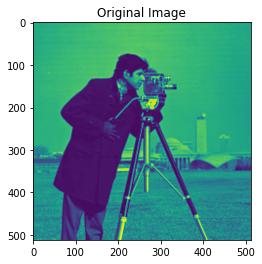

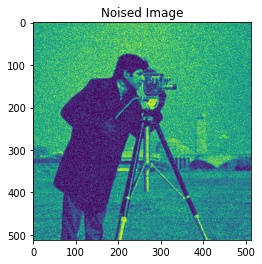

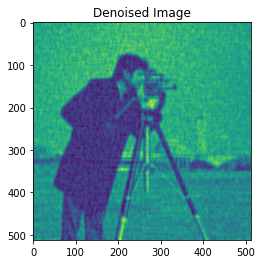

start transform 
start inverse transform
Denoised_MSE 1855.1455
Noised_MSE 6324.742
Ratio: 0.2933156


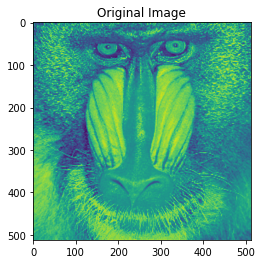

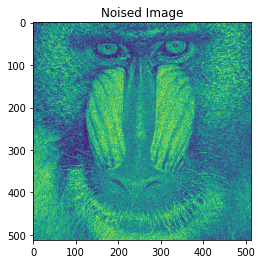

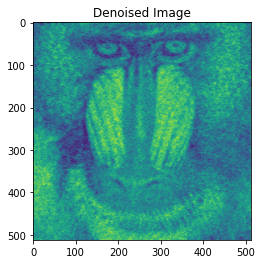

start transform 
start inverse transform
Denoised_MSE 1214.932
Noised_MSE 6132.6826
Ratio: 0.19810776


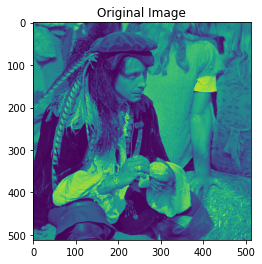

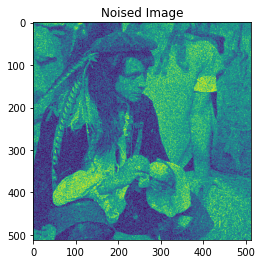

start transform 1
start transform 2
start transform 3
start inverse transform 1
start inverse transform 2
start inverse transform 3
starting put it all back together
Denoised_MSE 10847.639046584807
Noised_MSE 25286.518
Ratio: 0.42898904576599123


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


In [83]:
threshold_value = 500
variance_value = variances[3]

run_dct_test(test_files, threshold_value, variance_value, True, False)

## DCT Block

In [ ]:
def dct_blocks_transform_and_threshold(image, threshold_value, size_of_blocks):
    """
    Apply DCT Transform in blocks and Thresholds
    """


    index = 0
    image_height = len(image)
    image_width = len(image[0])
    transformed_image = {}
    for i in range(0, image_height - size_of_blocks, size_of_blocks):
        for j in range(0, image_width - size_of_blocks, size_of_blocks):
            small_matrix = image[i:i + size_of_blocks, j :j+size_of_blocks]
            transform = dct_transform(dct_transform(small_matrix).transpose()).transpose()

            transformed_image[index] = threshold(transform, threshold_value)
            index += 1

    print("Transformed Image index" +str(index))
    return transformed_image

def dct_blocks_inverse_transform(old_image, transformed_data, size_of_blocks):
    """
    Applys Inverse Transform in blocks and Puts all back together
    """
    image_height = len(old_image)
    image_width = len(old_image[0])
    new_image = np.zeros((image_height, image_width))
    index = 0

    for i in range(0, image_height - size_of_blocks, size_of_blocks):
        for j in range(0, image_width - size_of_blocks, size_of_blocks):
            small_matrix = transformed_data[index]
            inverse_transform = idct_transform(idct_transform(small_matrix).transpose()).transpose()
            new_image[i :i + size_of_blocks, j:j + size_of_blocks] = inverse_transform
            index += 1
    print("Inverse Transformed Image index" +str(index))
    return new_image

def run_dct_blocks_test(data, threshold_value, size_of_blocks, variance):
    print("Start DCT Test")
    for image_data_index in range(0, len(data)):

        

        image = data[image_data_index]["noisy_"+str(variance)]
        
        if(data[image_data_index]["type"] == "color"):
            red_image = image[:, :, 0]
            green_image = image[:, :, 1]
            blue_image = image[:, :, 2]

            print("start transform 1")
            transformed_threshold_red = dct_blocks_transform_and_threshold(red_image, threshold_value, size_of_blocks)  # transform and threshold
            print("start transform 2")
            transformed_threshold_blue = dct_blocks_transform_and_threshold(blue_image, threshold_value, size_of_blocks)
            print("start transform 3")
            transformed_threshold_green = dct_blocks_transform_and_threshold(green_image, threshold_value, size_of_blocks)

        

            # untransform
            print("start inverse transform 1")
            denoised_red = dct_blocks_inverse_transform(image,transformed_threshold_red, size_of_blocks)
            print("start inverse transform 2")
            denoised_blue = dct_blocks_inverse_transform(image,transformed_threshold_blue, size_of_blocks)
            print("start inverse transform 3")
            denoised_green = dct_blocks_inverse_transform(image,transformed_threshold_green, size_of_blocks)

            print("starting put it all back together")
            print(str(len(red_image)) +" " + str(len(red_image[0]))) #denoised red
            print(str(len(denoised_red)) +" " + str(len(denoised_red[0])))
            new_image = np.zeros((len(red_image), len(red_image[0]), 3))
            for i in range(0, len(red_image)):  # put it all back together
                for j in range(0, len(red_image[0])):
                    # print("i:" +str(i)+ " j:" + str(j))
                    new_image[i, j, 0] = denoised_red[i, j]
                    new_image[i, j, 1] = denoised_green[i, j]
                    new_image[i, j, 2] = denoised_blue[i, j]


            mse_denoised = np.sum(np.square(data[image_data_index]["raw_data"] - denoised_image))

          
            print("Denoised_MSE " + str(mse_denoised))
            print("Noised_MSE " + str(data[image_data_index]["mse_"+str(variance)]))
            print("Ratio: "+ str(mse_denoised / data[image_data_index]["mse_"+str(variance)]))

            plt.imshow(image)
            plt.show()

            plt.imshow(new_image)
            plt.show()
        else:           
                
            

                
            print("start transform ")
            transformed_threshold = dct_blocks_transform_and_threshold(image, threshold_value, size_of_blocks)

        
            print("start inverse transform")
            denoised_image = dct_blocks_inverse_transform(image,transformed_threshold, size_of_blocks)


            mse_denoised = np.sum(np.square(data[image_data_index]["raw_data"] - denoised_image))



            print("Denoised_MSE " + str(mse_denoised))
            print("Noised_MSE " + str(data[image_data_index]["mse_"+str(variance)]))
            print("Ratio: "+ str(mse_denoised / data[image_data_index]["mse_"+str(variance)]))

            plt.imshow(image)
            plt.show()

            plt.imshow(denoised_image)
            plt.show()



            


## DCT Block Test

In [1]:
# files =[{"name": "Rich_B", "raw_data":image, "type":"color"}]
# variance = .01

variance = variances[1]

threshold_value = .1
run_dct_blocks_test(test_files,threshold_value, 8, variance)

NameError: name 'variances' is not defined

# Thresholding 2 ELECtric Boogaloo
---
## Hadamard Transform
_AKA the Walsh–Hadamard transform, Hadamard–Rademacher–Walsh transform, Walsh transform, or Walsh–Fourier transform_

[Stack Exchange Discussion](https://dsp.stackexchange.com/questions/1693/what-is-the-walsh-hadamard-transform-and-what-is-it-good-for)
| [Hadamard Wikipedia](https://en.wikipedia.org/wiki/Hadamard_transform)
| [Fast Hadaramd Transform Wikipedia](https://en.wikipedia.org/wiki/Fast_Walsh%E2%80%93Hadamard_transform)

Hadamard Transforms were used by NASA in the early 60's and 70's due to it's computational simplicity.  
Because the matrix is comprised solely of $1$ and $-1$, every operation can be reduced to addition operations.  
New uses have arisen for the Hadamard transform in quantum computing. 

### Matrix Transform

Each entry in the Hadamard Matrix $H$ can be written:

$$(H_n)_{i,j} = \frac{1}{2^{\frac{n}{2}}}(-1)^{i\cdot j}$$

Where $i\cdot j$ represents the bitwise dot product of the binary representations of $i$ and $j$

### Fast Hadamard Transform

The Hadamard Matrix $H$ can also be created recursively, allowing for a divide and conquer algorithm.
The dimensions must be a multiple of 2.

## Haar Wavelet Transforms


In [ ]:
def one_dim_fast_hadamard_recurs(array, normalize = True):
    """
    Recursive algorithm for computing the hadamard transform on a vector.

    Input: array | numpy array of length n where n is a power of 2
    Input: normalize | boolean whether to normalize the output.  Normalizes if True.  Default is True.
    Output: output | numpy array of length n where n is a multiple of 2 representing the walsh 
            function of the input array
    """

    # Base Case    
    if(len(array) == 1):
        return array

    # Recursive Case
    else:
        # halfway point
        h = int(len(array)/2)
        
        # divide and conquer
        x = one_dim_fast_hadamard_recurs(array[:h], normalize = normalize)
        y = one_dim_fast_hadamard_recurs(array[h:], normalize = normalize)
        
        # Initialize output
        output = np.zeros(len(array))

        # compute output 
        for i in range(h):
            output[i] = x[i] + y[i]
            output[i + h] = x[i] - y[i]
        
        # normalize output if normalize is true
        if (normalize):
            output = (1/math.sqrt(2)) * output

        return output

def two_dim_fast_hadamard(matrix_i, normalize=True):
    """
    Computes the two dimensional Hadamard Transform on a matrix with dimensions that are powers of 2
    using the fast hadamard transform as a basis.

    Input: matrix_i | a two dimensional numpy array with the length of each dimension a multiple of two
    Input: normalize | boolean whether to normalize the output.  Normalizes if True.  Default is True.
    Output: output |  a two dimensional numpy array with length of each dimension a multiple of two composed
            composed of the hadamard transform of matrix_i
    """

    # Initialize output
    output = np.zeros(matrix_i.shape)

    # Transpose input matrix to iterate over rows rather than columns
    transpose_i = matrix_i.transpose()

    # Initialize matrix with one dimension transformed
    oneDim = np.zeros(transpose_i.shape)

    # Transform first dimension
    for i in range(len(transpose_i)):
        oneDim[i] = one_dim_fast_hadamard_recurs(transpose_i[i], normalize=normalize)

    # Transpose to work on rows
    oneDimTranspose = oneDim.transpose()

    # Transform second dimension
    for j in range(len(oneDimTranspose)):
        output[j] = one_dim_fast_hadamard_recurs(oneDimTranspose[j], normalize=normalize)

    return output

In [ ]:
# Helper Functions

# extracts Red, Green, and Blue arrays from an image and returns them in a tuple
def extractRGB(image_i):
    return np.array([image_i[:,:,0],image_i[:,:,1],image_i[:,:,2]])

# Compresses Red, Green, and blue arrays into an image
def compressRGB(red, green, blue):
    image = np.zeros((len(red), len(red[0]), 3))

    for i in range(len(red)):
        for j in range(len(red[0])):
            image[i][j][0] = red[i][j]
            image[i][j][1] = green[i][j]
            image[i][j][2] = blue[i][j]

    return image

# adds values to an array to make it have dimensions that are a power of 2
def zero_pad(image):

    xdim = math.log2(image.shape[1])
    ydim = math.log2(image.shape[0])

    output = image.copy()

    if(math.floor(ydim) != ydim):
        output = np.resize(output, (int(2 ** math.ceil(ydim)), image.shape[1]))

    if(math.floor(xdim) != xdim):
        output = np.resize(output.transpose(), (int(2 ** math.ceil(xdim)), len(output)))
        output = output.transpose()

    return output

# converts zero padded image back to its original size
def splice(image, original_x, original_y):
    return image[:original_y, :original_x]

def show_image(image, title):
    plt.imshow(image, interpolation='nearest', cmap='gray')
    plt.title(title)
    plt.show()
    return

In [ ]:
# Hadamard 
def run_hadamard_threshold(files, th, block=0):
    for picture in files:
        print("Start: " + picture["name"])
        dimensions = picture["noisy"].shape
        if picture["type"] == "color":
            rgb = extractRGB(picture["noisy"])

            if(block):
                redBlock = np.zeros((int(dimensions[0] / block), int(dimensions[1] / block), block, block))
                greenBlock = np.zeros((int(dimensions[0] / block), int(dimensions[1] / block), block, block))
                blueBlock = np.zeros((int(dimensions[0] / block), int(dimensions[1] / block), block, block))
                
                for i in range(dimensions[0]):
                    for j in range(dimensions[1]):
                        row = math.floor(i / block)
                        col = math.floor(j / block)
                        redBlock[row][col][i % block][j % block] = rgb[0][i][j]
                        greenBlock[row][col][i % block][j % block] = rgb[1][i][j]
                        blueBlock[row][col][i % block][j % block] = rgb[2][i][j]

                for rowBlock in range(len(redBlock)):
                    for colBlock in range(len(redBlock[0])):
                        redBlock[rowBlock][colBlock] = two_dim_fast_hadamard(threshold(two_dim_fast_hadamard(redBlock[rowBlock][colBlock]), th))
                        greenBlock[rowBlock][colBlock] = two_dim_fast_hadamard(threshold(two_dim_fast_hadamard(greenBlock[rowBlock][colBlock]), th))
                        blueBlock[rowBlock][colBlock] = two_dim_fast_hadamard(threshold(two_dim_fast_hadamard(blueBlock[rowBlock][colBlock]), th))

                reconstructedImage = np.zeros(dimensions)

                for k in range(dimensions[0]):
                    for l in range(dimensions[1]):
                        row = math.floor(k / block)
                        col = math.floor(l / block)
                        reconstructedImage[k][l][0] = redBlock[row][col][k % block][l % block]
                        reconstructedImage[k][l][1] = greenBlock[row][col][k % block][l % block]
                        reconstructedImage[k][l][2] = blueBlock[row][col][k % block][l % block]
            else:
                redHadamard = threshold(two_dim_fast_hadamard(zero_pad(rgb[0])), th)
                greenHadamard = threshold(two_dim_fast_hadamard(zero_pad(rgb[1])), th)
                blueHadamard = threshold(two_dim_fast_hadamard(zero_pad(rgb[2])), th)

                redFiltered = splice(two_dim_fast_hadamard(redHadamard), dimensions[1], dimensions[0])
                greenFiltered = splice(two_dim_fast_hadamard(greenHadamard), dimensions[1], dimensions[0])
                blueFiltered = splice(two_dim_fast_hadamard(blueHadamard), dimensions[1], dimensions[0])

                reconstructedImage = compressRGB(redFiltered, greenFiltered, blueFiltered)
        else:
            if(block):
                    blackWhiteBlock = np.zeros((int(dimensions[0] / block), int(dimensions[1] / block), block, block))
                    
                    for i in range(dimensions[0]):
                        for j in range(dimensions[1]):
                            row = math.floor(i / block)
                            col = math.floor(j / block)
                            blackWhiteBlock[row][col][i % block][j % block] = picture["noisy"][i][j]

                    for rowBlock in range(len(blackWhiteBlock)):
                        for colBlock in range(len(blackWhiteBlock[0])):
                            blackWhiteBlock[rowBlock][colBlock] = two_dim_fast_hadamard(threshold(two_dim_fast_hadamard(blackWhiteBlock[rowBlock][colBlock]), th))

                    reconstructedImage = np.zeros(dimensions)

                    for k in range(dimensions[0]):
                        for l in range(dimensions[1]):
                            row = math.floor(k / block)
                            col = math.floor(l / block)
                            reconstructedImage[k][l] = blackWhiteBlock[row][col][k % block][l % block]
            else:
                blackWhiteHadamard = threshold(two_dim_fast_hadamard(zero_pad(picture["noisy"])), th)

                reconstructedImage = splice(two_dim_fast_hadamard(blackWhiteHadamard), dimensions[1], dimensions[0])

        show_image(picture["noisy"], picture["name"] + " Noisy")
        show_image(reconstructedImage, picture["name"] + " Filtered")
        show_image(picture["raw_data"], picture["name"] + " Original")

    return True



In [ ]:
def mse(original, new):
    return np.sum(np.square(original - new))

Start: cameraman


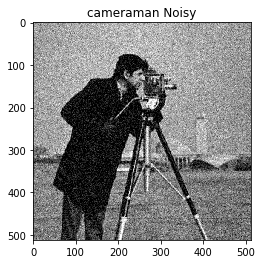

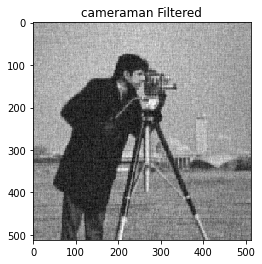

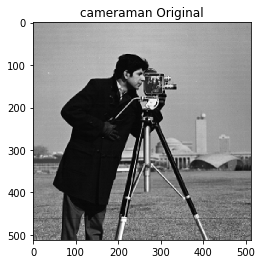

Start: kodim01


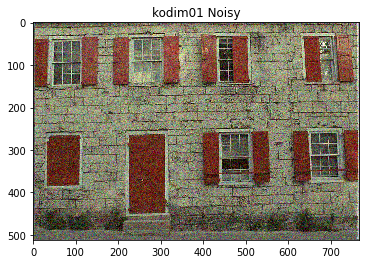

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


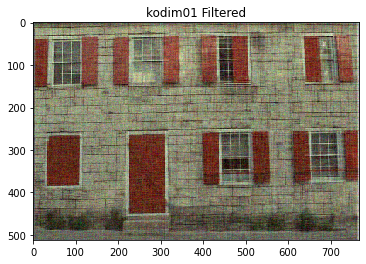

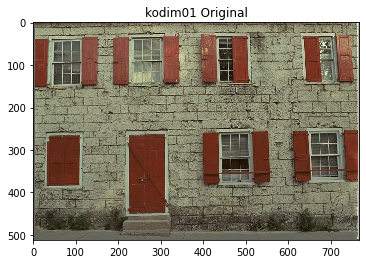

Start: kodim02


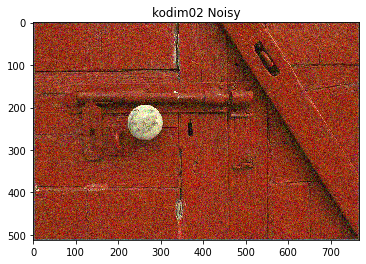

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


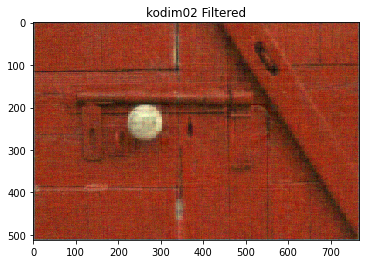

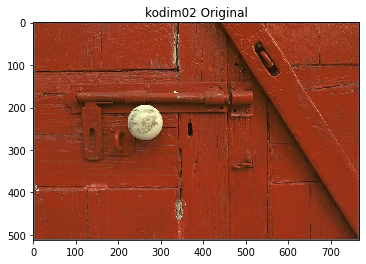

True

In [ ]:
# hadamard filter
run_hadamard_threshold(files[0:3], .3)

Start: cameraman


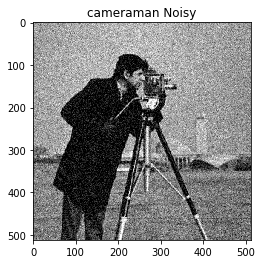

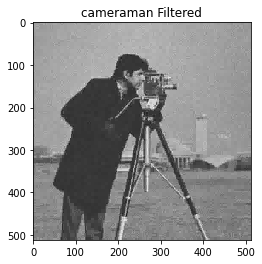

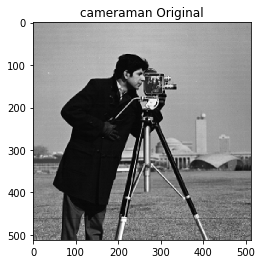

Start: kodim01


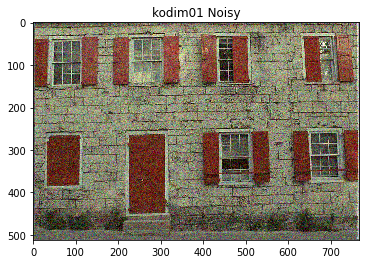

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


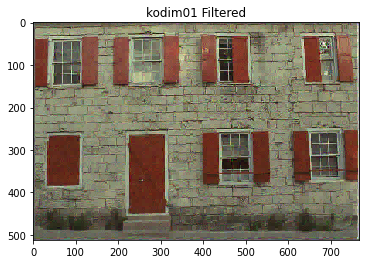

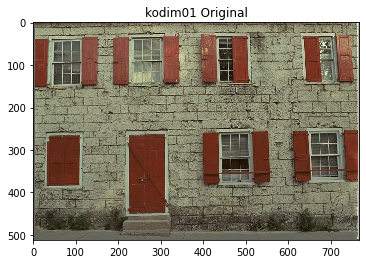

Start: kodim02


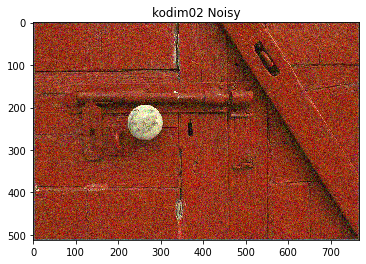

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


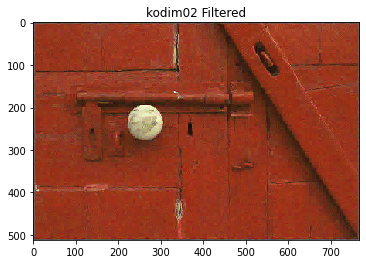

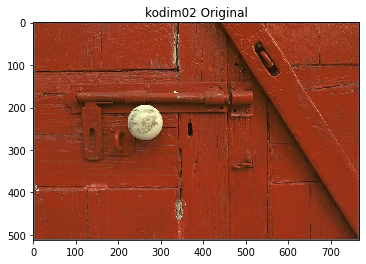

True

In [ ]:
# hadamard block filter
run_hadamard_threshold(files[0:3], .3, block=8)

********************************************************************************************
Hadamard Test Frequency:
[ 1.41421356  0.70710678  0.         -0.70710678  0.          0.70710678
  0.          0.70710678]
********************************************************************************************
Hadamard Back Again Test: 
[ 1.00000000e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -7.85046229e-17  1.00000000e+00  1.00000000e+00  0.00000000e+00]
********************************************************************************************
Two Dimensional Hadamard Test:
[[ 6. -2.]
 [-1.  1.]]
********************************************************************************************
Two Dimensional Hadamard Back Again Test:
[[2. 3.]
 [2. 5.]]
********************************************************************************************


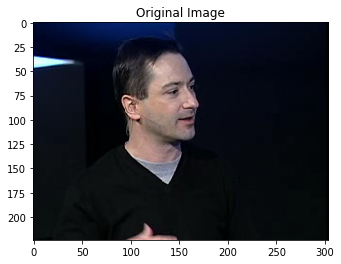

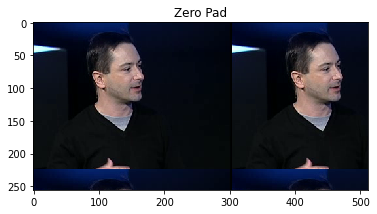

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


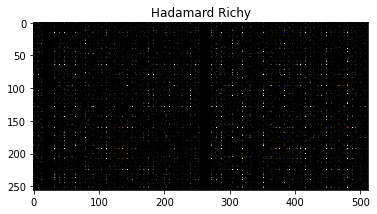

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


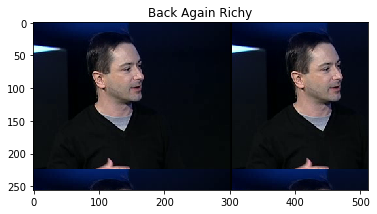

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


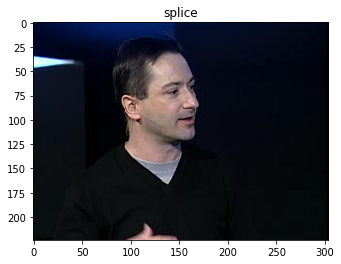

In [ ]:
# Hadamard Test Suite

divider = "********************************************************************************************"

# One Dimensional Recursion There and Back Again Test
test = [1, 0, 1, 0, 0, 1, 1, 0]
hadamardTest = one_dim_fast_hadamard_recurs(test)
print(divider)
print("Hadamard Test Frequency:")
print(hadamardTest)
print(divider)
backAgain = one_dim_fast_hadamard_recurs(hadamardTest)
print("Hadamard Back Again Test: ")
print(backAgain)
print(divider)

# Two dimensional there and back again test
test2 = np.array([[2,3],[2,5]])
twoDimTest = two_dim_fast_hadamard(test2)
print("Two Dimensional Hadamard Test:")
print(twoDimTest)
print(divider)
test2BackAgain = two_dim_fast_hadamard(twoDimTest)
print("Two Dimensional Hadamard Back Again Test:")
print(test2BackAgain)
print(divider)

# Richyb test
image = im.imread("richb8.png")
data = np.asarray(image)
show_image(data, "Original Image")

rgb = extractRGB(data)


zeropadRGB = [zero_pad(rgb[0]), zero_pad(rgb[1]), zero_pad(rgb[2])]
zeropad = compressRGB(zeropadRGB[0], zeropadRGB[1], zeropadRGB[2])


show_image(zeropad, "Zero Pad")

richyRed = two_dim_fast_hadamard(zeropadRGB[0], normalize=True)
richyGreen = two_dim_fast_hadamard(zeropadRGB[1], normalize=True)
richyBlue = two_dim_fast_hadamard(zeropadRGB[2], normalize=True)

transformedRichy = compressRGB(richyRed, richyGreen, richyBlue)

show_image(transformedRichy, "Hadamard Richy")

extractedRGB = extractRGB(transformedRichy)

richyRed2 =  two_dim_fast_hadamard(extractedRGB[0],normalize=True)
richyGreen2 =  two_dim_fast_hadamard(extractedRGB[1], normalize=True)
richyBlue2 =   two_dim_fast_hadamard(extractedRGB[2], normalize=True)

backAgainRichy = compressRGB(richyRed2, richyGreen2, richyBlue2)

show_image(backAgainRichy, "Back Again Richy")

richsplice = splice(backAgainRichy, 304, 224)

show_image(richsplice, 'splice')


In [ ]:
m = math.log2(256)
print(math.floor(m) == int(m))

True


## Other stuff

2400.939688986149
0.4639765
Variance: 0.009140217226424168


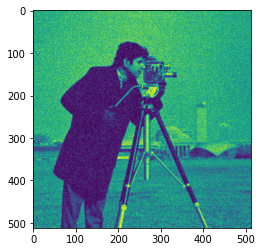

Max: 1.0
Mean: 0.4640021438598633
MSE: 243.17119480736716
Variance: 2.4366729745286166e-06


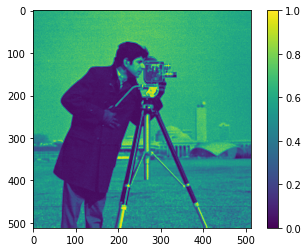

Max: 1.0
Mean: 0.46394605636596675
MSE: 1514.3231639294247
Variance: 9.272808368350125e-05


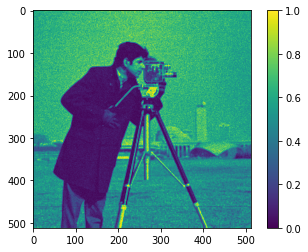

Max: 1.0
Mean: 0.4618471145629882
MSE: 5670.136925400022
Variance: 0.00109565084081559


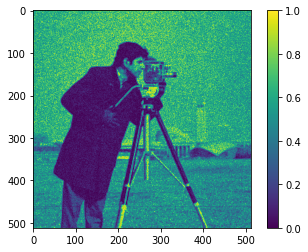

Max: 1.0
Mean: 0.4552364349365233
MSE: 10196.275374796438
Variance: 0.0030343031178495256


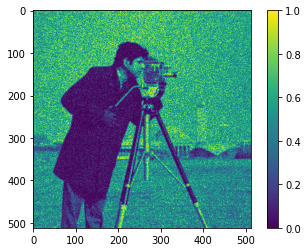

2585.1191417749806
0.48646072
Variance: 0.009861445073973215


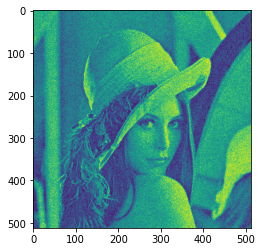

Max: 1.0
Mean: 0.4864611358642577
MSE: 254.9497892940266
Variance: 2.3384010757244094e-06


Max: 1.0
Mean: 0.4862864017486572
MSE: 1579.234500281016
Variance: 8.502062813082151e-05


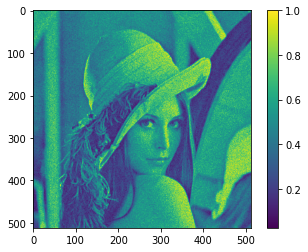

Max: 1.0
Mean: 0.4838157653808594
MSE: 5903.9647129246105
Variance: 0.0010562498371665418


Max: 1.0
Mean: 0.4777324676513671
MSE: 10856.658393693817
Variance: 0.0031434504187154927


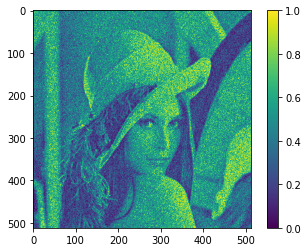

2598.912095551024
0.5038399
Variance: 0.009914053459532099


Max: 0.924
Mean: 0.5038524398803712
MSE: 263.3860537635759
Variance: 2.308262786908579e-06


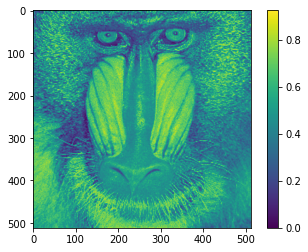

Max: 1.0
Mean: 0.503972578048706
MSE: 1643.5848338604314
Variance: 8.917974939070243e-05


Max: 1.0
Mean: 0.5016105651855468
MSE: 6236.057013981395
Variance: 0.0010965993031573857


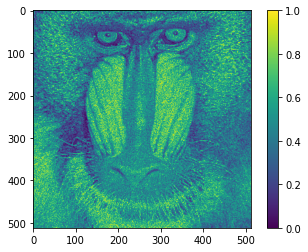

Max: 1.0
Mean: 0.4962642669677735
MSE: 11494.215398187804
Variance: 0.003248275622345787


In [ ]:
# Poisson "shot" noise

# Add poisson noise 
from PIL import Image

img_nums = [0, 28, 31]
for img_num in img_nums:
    img_current = files[img_num]

    print(img_current["mse"])
    print(img_current["raw_data"].mean())
    print(f"Variance: {np.var(img_current['noisy']-img_current['raw_data'])}")
    plt.imshow(img_current["noisy"])
    plt.show()
    im = Image.fromarray(img_current["raw_data"] * 255)
    im = im.convert('L')
    im.save(f'poisson/{img_current["name"]}.png', "png")

    scalings = [ 500, 80, 20, 10]
    for scaling in scalings:
        noise = ((np.random.poisson( (img_current["raw_data"]) * scaling) )  / scaling).clip(0, 1)
        print(f'Max: {noise.max()}')
        print(f'Mean: {noise.mean()}')
        # print(noise)
        print(f'MSE: {np.sum(np.square(img_current["raw_data"] - noise))}')
        print(f'Variance: {np.var(np.square(img_current["raw_data"] - noise))}')
        plt.imshow(noise)
        # plt.imshow(np.abs(noise - (img_current["raw_data"])), cmap="gray")
        plt.colorbar()
        plt.show()
        im = Image.fromarray(noise * 255)
        im = im.convert('L')
        im.save(f'poisson/{img_current["name"]}_{scaling}_poisson.png', "png")
# plt.imshow(img_current["raw_data"], cmap = "gray")
# plt.show()
# plt.imshow(noise, cmap = "gray")
# plt.show()
# plt.imshow(img_current["noisy"], cmap = "gray")
# plt.show()

In [ ]:
# BM3D Denoising

def bm3d_denoise(image):
    # Show the noisy image
    noisy = image["noisy"]
    print("Noisy image")
    plt.imshow(noisy)
    plt.show()
    # Set up the output
    dims = noisy.shape
    output = np.zeros(dims)
    # Denoise the image
    if image["type"] == "color":
        out_red = bm3d.bm3d(noisy[:,:,0],sigma_psd=0.2,stage_arg=bm3d.BM3DStages.HARD_THRESHOLDING)
        out_green[:,:,1] = bm3d.bm3d(noisy[:,:,1],sigma_psd=0.2,stage_arg=bm3d.BM3DStages.HARD_THRESHOLDING)
        out_blue[:,:,2] = bm3d.bm3d(noisy[:,:,2],sigma_psd=0.2,stage_arg=bm3d.BM3DStages.HARD_THRESHOLDING)
        output = compressRGB(out_red,out_green,out_blue)
    else:
        output = bm3d.bm3d(noisy,sigma_psd=0.2,stage_arg=bm3d.BM3DStages.HARD_THRESHOLDING)
    # Show the denoised image 
    print("After some CLARG magic")    
    plt.imshow(output)
    plt.show()
    return    


Noisy image


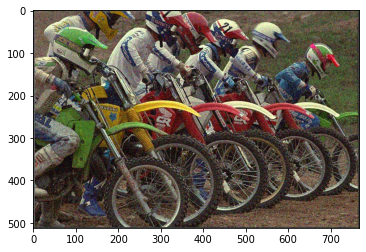

Exception: OpenBLAS library not found!

In [ ]:
# BM3D Tests
bm3d_denoise(files[5])